In [3]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import root_mean_squared_error
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def prepare_dataset(segments, ph, history):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carb_effect'] = pd.to_numeric(segment_df['carb_effect'], errors='coerce')
        segment_df['steps'] = pd.to_numeric(segment_df['steps'], errors='coerce')
        segment_df['steps'] = segment_df['steps'] 
        segment_df['bolus_effect'] = pd.to_numeric(segment_df['bolus_effect'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history-1+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + history-1 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+history-1
            features = segment_df.loc[i:i+history-1, ['glucose_value',  'bolus_effect', 'carb_effect', 'steps']] # .values.flatten() # 'carb_effect', 'bolus_effect', 'steps'
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+history-1+ph, 'glucose_value'] - segment_df.loc[i+history-1, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history-1+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, raw_glu_list

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim


class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob).to(device)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor

        # Initialize hidden and cell state for the first LSTM layer
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Dropout layer
        out = self.dropout(out)
        
        # Initialize hidden and cell state for the second LSTM layer
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (h1, c1))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out


In [86]:
# Load processed data
filename = "./processed_data/559_combined_segments_noshrink.pkl"
# Load the dictionary from the file
with open(filename, 'rb') as f:
    loaded_df_dict = pickle.load(f)

# Verify the content


print(loaded_df_dict['segment_1'])
print(loaded_df_dict['segment_2'])
step_updated_segments = loaded_df_dict





              timestamp  glucose_value  carb_effect  bolus_effect  steps
0   2021-12-07 01:20:00            101            0          1.46    NaN
1   2021-12-07 01:25:00             98            0          1.39    NaN
2   2021-12-07 01:30:00            104            0          1.32    NaN
3   2021-12-07 01:35:00            112            0          1.25    NaN
4   2021-12-07 01:40:00            120            0          1.18    NaN
..                  ...            ...          ...           ...    ...
223 2021-12-07 19:55:00             96           54          2.09    0.9
224 2021-12-07 20:00:00             93           51          2.02    4.6
225 2021-12-07 20:05:00             86           49          1.95    3.9
226 2021-12-07 20:10:00             86           47          1.88    3.2
227 2021-12-07 20:15:00             86           45          1.81    8.8

[228 rows x 5 columns]
              timestamp  glucose_value  carb_effect  bolus_effect      steps
0   2021-12-08 00:05:00

In [88]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
import os

# Prepare for training
ph = 6
features_list, labels_list, raw_glu_list = prepare_dataset(step_updated_segments, ph, 6) # segments, ph, history

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

# X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)

# Assuming your StackedLSTM model class is defined elsewhere
input_size = 2
hidden_size = 128
num_layers = 2
output_size = 1
dropout_prob = 0.2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming X, y are your complete dataset arrays
X = torch.tensor(features_array, dtype=torch.float32).to(device)
y = torch.tensor(labels_array, dtype=torch.float32).to(device)

# Set up K-Fold Cross Validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)





len of features_list 10334
len of labels_list 10334


In [90]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
import os

# Assuming your StackedLSTM model class is defined elsewhere
input_size = 4
hidden_size = 128
num_layers = 2
output_size = 1
dropout_prob = 0.2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming X, y are your complete dataset arrays
X = torch.tensor(features_array, dtype=torch.float32).to(device)
y = torch.tensor(labels_array, dtype=torch.float32).to(device)

# Set up K-Fold Cross Validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)

# Prepare a directory to save models
model_dir = 'model_checkpoints_559'
os.makedirs(model_dir, exist_ok=True)

num_epochs = 50

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f'Fold {fold + 1}/{num_folds}')
    
    # Sample data for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Create Datasets and Loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model, criterion, and optimizer for each fold
    model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
         # Forward pass
    
    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Reshape targets to match output shape
            targets = targets.view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            

                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')
            
        model.eval()
        with torch.no_grad():
            total_loss = 0
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())
                total_loss += loss.item()
            
            avg_loss = total_loss / len(val_loader)
            print(f'Test Loss: {avg_loss:.4f}')
            
    fold_path = os.path.join(model_dir, f'model_fold_{fold + 1}.pth')
    torch.save(model.state_dict(), fold_path)

         



Fold 1/5
Epoch [1/50], Training Loss: 7307.3511
Test Loss: 14307.5477
Epoch [2/50], Training Loss: 72.1778
Test Loss: 5417.2161
Epoch [3/50], Training Loss: 88.9809
Test Loss: 5321.7153
Epoch [4/50], Training Loss: 627.0586
Test Loss: 4316.7799
Epoch [5/50], Training Loss: 694.4632
Test Loss: 3072.1192
Epoch [6/50], Training Loss: 487.5736
Test Loss: 2817.6849
Epoch [7/50], Training Loss: 438.1194
Test Loss: 2757.4304
Epoch [8/50], Training Loss: 322.9451
Test Loss: 2742.0956
Epoch [9/50], Training Loss: 366.3765
Test Loss: 2741.8819
Epoch [10/50], Training Loss: 373.5218
Test Loss: 2747.0729
Epoch [11/50], Training Loss: 331.1242
Test Loss: 2754.2200
Epoch [12/50], Training Loss: 314.8320
Test Loss: 2762.3612
Epoch [13/50], Training Loss: 216.3070
Test Loss: 2766.7437
Epoch [14/50], Training Loss: 336.7047
Test Loss: 2778.2575
Epoch [15/50], Training Loss: 217.6444
Test Loss: 2784.2347
Epoch [16/50], Training Loss: 181.6808
Test Loss: 2802.5115
Epoch [17/50], Training Loss: 144.4483
T

c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Training Loss: 508.6695
Test Loss: 5099.0025
Epoch [3/50], Training Loss: 946.7534
Test Loss: 5020.0195
Epoch [4/50], Training Loss: 747.4001
Test Loss: 4784.8802
Epoch [5/50], Training Loss: 1590.6556
Test Loss: 3200.0495
Epoch [6/50], Training Loss: 1843.3533
Test Loss: 2819.8091
Epoch [7/50], Training Loss: 1581.8177
Test Loss: 2676.7196
Epoch [8/50], Training Loss: 1366.8099
Test Loss: 2613.2959
Epoch [9/50], Training Loss: 1135.4626
Test Loss: 2579.0053
Epoch [10/50], Training Loss: 1337.3992
Test Loss: 2537.5572
Epoch [11/50], Training Loss: 1355.6635
Test Loss: 2522.5007
Epoch [12/50], Training Loss: 1132.2510
Test Loss: 2509.1152
Epoch [13/50], Training Loss: 1062.1219
Test Loss: 2486.0229
Epoch [14/50], Training Loss: 1025.4219
Test Loss: 2465.9699
Epoch [15/50], Training Loss: 885.5054
Test Loss: 2438.3382
Epoch [16/50], Training Loss: 1022.0211
Test Loss: 2451.9425
Epoch [17/50], Training Loss: 941.6301
Test Loss: 2436.0701
Epoch [18/50], Training Loss: 779.482

In [24]:
# input_size = 2 # Number of input features
# hidden_size = 128  # Hidden vector size
# num_layers = 2  # Number of LSTM layers
# output_size = 1  # Single output
# dropout_prob = 0.2  # Dropout probability

# model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [25]:
# # # # save the model 
# torch.save(model.state_dict(), './model_checkpoints/model_fold_2.pth')

In [91]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {np.sqrt(rmse)}')

RMSE on validation set: 26.780414581298828


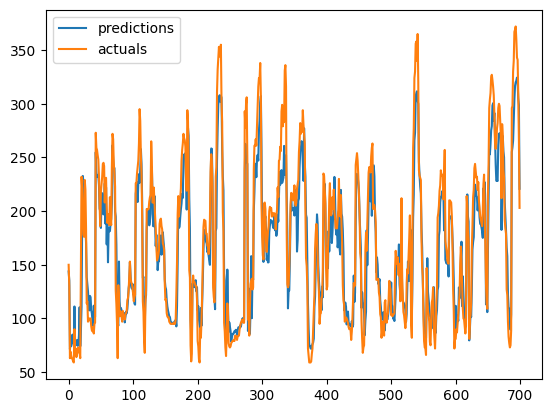

In [11]:
plt.plot(predictions[:700], label = 'predictions')
plt.plot(actuals[:700], label = 'actuals')
plt.legend()

# Testing

In [24]:
def test_model(model, test_step_updated_segments):

    # Prepare for training"
    features_list_test, labels_list_test, raw_glu_list_test = prepare_dataset(test_step_updated_segments, 6, 6)
    
    # Build training and validation loader
    features_array_test = np.array(features_list_test)
    labels_array_test = np.array(raw_glu_list_test) # Maybe need to replace this

    X_test, y_test = features_array_test, labels_array_test

    # Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs)
            actuals.append(targets)

    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()

    rmse = np.sqrt(mean_squared_error(actuals,predictions))
    print(f'RMSE on validation set: {rmse}')
    
    return predictions, actuals, rmse

# Testing

In [92]:
# load model from .pth

fold_num = 1

model_dir = f"./model_checkpoints_559/model_fold_{fold_num}.pth"
input_size = 4 # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [93]:
import glob




preds = []
trues = []
errors = []
fname = []

for file in glob.glob("./processed_data/*test*shrink.pkl"):
    test_filename = file
    with open(test_filename, 'rb') as f:
        test_loaded_df_dict = pickle.load(f)

    # Verify the content
    test_step_updated_segments = test_loaded_df_dict
    pred, true, rmse = test_model(model, test_step_updated_segments)
    preds.append(pred)
    trues.append(true)
    errors.append(rmse)
    fname.append(file.split('\\')[-1].split('_')[0])


len of features_list 2393
len of labels_list 2393
RMSE on validation set: 22.451120376586914
len of features_list 2537
len of labels_list 2537
RMSE on validation set: 26.09510040283203
len of features_list 2635
len of labels_list 2635
RMSE on validation set: 33.678531646728516
len of features_list 2480
len of labels_list 2480
RMSE on validation set: 29.97041130065918
len of features_list 2758
len of labels_list 2758
RMSE on validation set: 21.282705307006836
len of features_list 2716
len of labels_list 2716
RMSE on validation set: 23.253759384155273


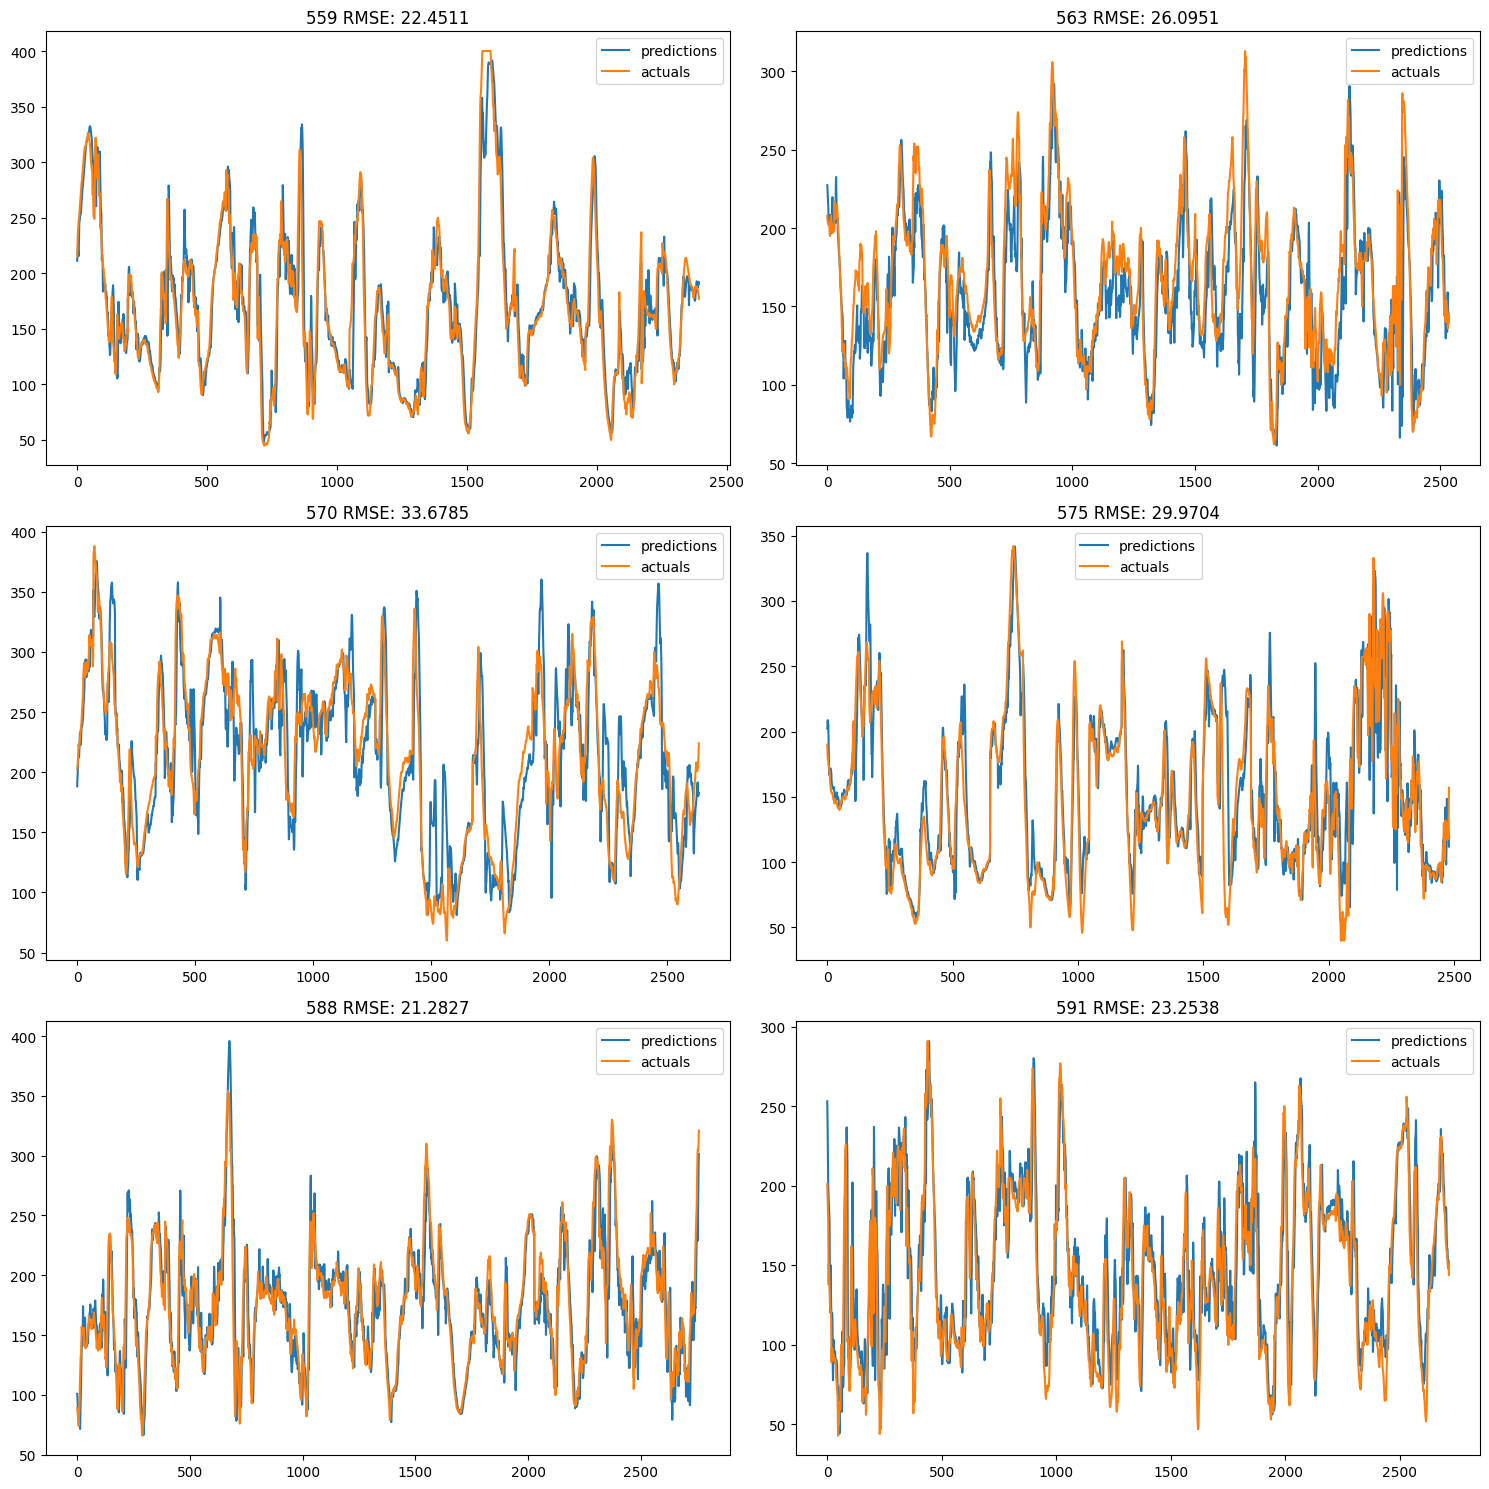

In [94]:
# make a 3x 2 plot and plot the preds and actuals of each one in each and have the title be the filename and the rmse

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i in range(3):
    for j in range(2):
        idx = i*2 + j
        axs[i, j].plot(preds[idx], label = 'predictions')
        axs[i, j].plot(trues[idx], label = 'actuals')
        axs[i, j].legend()
        axs[i, j].set_title(f'{fname[idx]} RMSE: {errors[idx]:.4f}')
        
plt.tight_layout()

In [70]:
# convert this all to a table 
# save the table as a csv
# convert the fname and the rmse to a dataframe
curr_dat = pd.DataFrame({'fname': fname, 'rmse': errors})


In [71]:
curr_dat.to_csv(f'fold_{fold_num}_sampling_horizon{ph}_ALL.csv', index=False)

In [95]:
curr_dat

,fname,rmse,fold
0,559,18.968067,5
1,563,18.325712,5
2,570,15.486623,5
3,575,22.932762,5
4,588,18.268776,5
5,591,20.925867,5


In [75]:
# import the files with the foldname 
file_dir = "./fold*6.csv"
dirs = glob.glob(file_dir)

['.\\fold_1_sampling_horizon6.csv',
 '.\\fold_1_sampling_horizon6_ALL.csv',
 '.\\fold_2_sampling_horizon6.csv',
 '.\\fold_3_sampling_horizon6.csv',
 '.\\fold_4_sampling_horizon6.csv',
 '.\\fold_5_sampling_horizon6.csv']

In [77]:
dfs = []
for path in dirs: 
    curr_dat = pd.read_csv(path)
    curr_dat['fold'] = path.split('_')[1]
    dfs.append(curr_dat)
    
all_dat = pd.concat(dfs)

all_dat = all_dat.pivot(index='fname', columns='fold', values='rmse').reset_index()

all_dat

fold,fname,1,2,3,4,5
0,559,18.952497,18.880981,18.901442,19.051620,18.968067
1,563,18.453913,18.540073,18.508923,18.157000,18.325712
2,570,16.473244,15.673701,15.720717,16.538713,15.486623
3,575,23.145523,23.139967,23.051077,22.706915,22.932762
4,588,18.420820,18.332333,18.370024,18.166988,18.268776
5,591,21.036766,21.069658,20.887400,20.740280,20.925867


In [79]:
# print the averages of each column 
# make fname the index"
all_dat.set_index('fname', inplace=True)
all_dat['avg'] = all_dat.mean(axis=1)

In [82]:
all_dat.to_csv('k_folds_ph_6_ALL.csv')

In [84]:
all_dat

fold,1,2,3,4,5,avg
fname,,,,,,
559,18.952497,18.880981,18.901442,19.051620,18.968067,18.950921
563,18.453913,18.540073,18.508923,18.157000,18.325712,18.397124
570,16.473244,15.673701,15.720717,16.538713,15.486623,15.978600
575,23.145523,23.139967,23.051077,22.706915,22.932762,22.995249
588,18.420820,18.332333,18.370024,18.166988,18.268776,18.311788
591,21.036766,21.069658,20.887400,20.740280,20.925867,20.931994


In [83]:
# load results of prediction_horizon_6.csv
eighty_20 = pd.read_csv('prediction_horizon_6.csv')
eighty_20

,fname,rmse
0,559,27.187637
1,563,21.716558
2,570,24.688730
3,575,29.442541
4,588,22.270994
5,591,26.982765
